# Investigation
We will be investigating what variables will have the most impact on a house's market price.  We will be investigating from the perspective of a start up company which buys inexpensive houses and "flips" them for profit.

## Objectives:

* Find what aspects of a house have a significant impact on house's value
* Discover how much a house's value will change based on a changes in condition
* Find the areas that are more profitable to sell homes. 

# Obtaining data
Time to import the necessary libraries and initialize a data frame containing the data from the CSV file.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

## Initializing data frame

In [2]:
df = pd.read_csv('csv_files/kc_house_data.csv')
print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB
None


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062


# Scrubbing the Data
Now that the data frame has been initialized, we'll start cleaning.

Notes: Problems that I can immediately see are: 
* waterfront, view, and yr_renovated are missing values. 
* sqft_basement and dates are objects instead of integer/float and datetime, respectively. 

## Waterfront

In [3]:
print(df.waterfront.value_counts())
waterfront = df[df['waterfront'] == 1.0]
waterfront['price'].describe()


0.0    19075
1.0      146
Name: waterfront, dtype: int64


count    1.460000e+02
mean     1.717215e+06
std      1.145385e+06
min      2.850000e+05
25%      8.275000e+05
50%      1.510000e+06
75%      2.282500e+06
max      7.060000e+06
Name: price, dtype: float64

In [4]:
# Looked at low end prices of waterfront properties out of curiousity.
# waterfront will play a significant role in price.  Replacing NaN's with 
# median
df.waterfront.fillna(df['waterfront'].median(), inplace=True)
df.waterfront.isna().sum()

0

## Yr_renovated

In [5]:
# Checking out yr_renovated  ***Take deeper look into this***
df.yr_renovated.value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [6]:
# Since having data about renovated homes might be useful, filling NaN's with
# median
df.yr_renovated.fillna(df['yr_renovated'].median())

0           0.0
1        1991.0
2           0.0
3           0.0
4           0.0
          ...  
21592       0.0
21593       0.0
21594       0.0
21595       0.0
21596       0.0
Name: yr_renovated, Length: 21597, dtype: float64

### Is 'yr_renovated' categorical? 

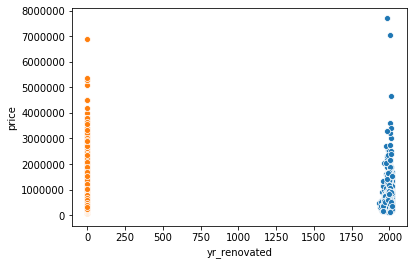

In [7]:
# checking the impact of homes renovated versus not renovated against price

no_reno = df[df['yr_renovated'] == 0]

reno = df[df['yr_renovated'] != 0]

sns.scatterplot(x=reno['yr_renovated'], y=reno['price'])
sns.scatterplot(x=no_reno['yr_renovated'], y=no_reno['price'])

The columns 'yr_renovated' is categorical so we'll alter data frame to represent this.  Renovated homes will be represented by a 1 and non-renovated homes will be represented by a 0. 

In [9]:
for i in range(len(df['yr_renovated'])):
    if df['yr_renovated'].iloc[i] != 0.0:
        df['yr_renovated'].iloc[i] = 1.0
# change name to just renovated
df = df.rename(columns={'yr_renovated' : 'renovated'})

In [10]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,1.0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


Judging from this graph, and knowing that the number of non-renovated homes far exceeds the number of renovated homes, I see that whether a home has been renovated or not has 

## View

In [10]:
# view column refers to how many times the home has been viewed
print(df.view.value_counts())
df.isnull().sum()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64


id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
view             63
condition         0
grade             0
sqft_above        0
sqft_basement     0
yr_built          0
renovated         0
zipcode           0
lat               0
long              0
sqft_living15     0
sqft_lot15        0
dtype: int64

In [21]:
# Only 63 missing values. Home views could potentially lead us to areas where 
# people are looking to purchase homes; advise not dropping column. This data
# only makes up 0.29% of our data. Solution: Drop rows.
df.dropna(axis=0, inplace=True)
df.view.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: view, dtype: float64

## Date

In [12]:
# Time to deal with object types.
df.date.head()

0    10/13/2014
1     12/9/2014
2     2/25/2015
3     12/9/2014
4     2/18/2015
Name: date, dtype: object

In [13]:
# convert 'date' to datetime
df.date = pd.to_datetime(df['date'], format="%m/%d/%Y")
df['date'].head()

0   2014-10-13
1   2014-12-09
2   2015-02-25
3   2014-12-09
4   2015-02-18
Name: date, dtype: datetime64[ns]

## Sqft_Basement

In [14]:
# inspecting sqft_basement values
df['sqft_basement'].value_counts()

0.0       12798
?           452
600.0       216
500.0       209
700.0       207
          ...  
506.0         1
1930.0        1
652.0         1
1840.0        1
176.0         1
Name: sqft_basement, Length: 302, dtype: int64

In [15]:
# 452 values of '?'. Makes up 2.1% of our data. 
med_bsmt = df[df['sqft_basement'] != '?']
med = med_bsmt.sqft_basement.median()

for i in range(len(df['sqft_basement'])):
    if df['sqft_basement'].iloc[i] == '?':
        df['sqft_basement'].iloc[i] = str(med)


df.sqft_basement.value_counts()

0.0       13250
600.0       216
500.0       209
700.0       207
800.0       201
          ...  
506.0         1
1930.0        1
652.0         1
1840.0        1
176.0         1
Name: sqft_basement, Length: 301, dtype: int64

In [16]:
# convert to float
df['sqft_basement'] = df.sqft_basement.astype(float)
df.sqft_basement.dtype

dtype('float64')

### Change to Categorical Format

In [17]:
for i in range(len(df['sqft_basement'])):
    if df['sqft_basement'].iloc[i] != 0.0:
        df['sqft_basement'].iloc[i] = 1.0
        
df = df.rename(columns={'sqft_basement' : 'basement'})
df.basement.head()

0    0.0
1    1.0
2    0.0
3    1.0
4    0.0
Name: basement, dtype: float64

## Checking for duplicates

In [18]:
# checking for duplicates
dups = df[df.duplicated(['id'],keep=False)]
dups.groupby('id', axis=1)
dups


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,basement,yr_built,renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,2014-07-25,430000.0,3,1.50,1580,5000,1.0,0.0,0.0,...,8,1290,1.0,1939,0.0,98117,47.6870,-122.386,1570,4500
94,6021501535,2014-12-23,700000.0,3,1.50,1580,5000,1.0,0.0,0.0,...,8,1290,1.0,1939,0.0,98117,47.6870,-122.386,1570,4500
313,4139480200,2014-06-18,1380000.0,4,3.25,4290,12103,1.0,0.0,3.0,...,11,2690,1.0,1997,0.0,98006,47.5503,-122.102,3860,11244
314,4139480200,2014-12-09,1400000.0,4,3.25,4290,12103,1.0,0.0,3.0,...,11,2690,1.0,1997,0.0,98006,47.5503,-122.102,3860,11244
324,7520000520,2014-09-05,232000.0,2,1.00,1240,12092,1.0,0.0,0.0,...,6,960,1.0,1922,1.0,98146,47.4957,-122.352,1820,7460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20654,8564860270,2015-03-30,502000.0,4,2.50,2680,5539,2.0,0.0,0.0,...,8,2680,0.0,2013,0.0,98045,47.4759,-121.734,2680,5992
20763,6300000226,2014-06-26,240000.0,4,1.00,1200,2171,1.5,0.0,0.0,...,7,1200,0.0,1933,0.0,98133,47.7076,-122.342,1130,1598
20764,6300000226,2015-05-04,380000.0,4,1.00,1200,2171,1.5,0.0,0.0,...,7,1200,0.0,1933,0.0,98133,47.7076,-122.342,1130,1598
21564,7853420110,2014-10-03,594866.0,3,3.00,2780,6000,2.0,0.0,0.0,...,9,2780,0.0,2013,0.0,98065,47.5184,-121.886,2850,6000


In [19]:
# duplicates indicate that the houses were sold more than once. Creating 
# subset  of data to see if duplicates were purchased by house flippers
flips = dups[['id', 'date', 'price', 'condition', 'grade']]
flips.head(20)

,id,date,price,condition,grade
93,6021501535,2014-07-25,430000.0,3,8
94,6021501535,2014-12-23,700000.0,3,8
313,4139480200,2014-06-18,1380000.0,3,11
314,4139480200,2014-12-09,1400000.0,3,11
324,7520000520,2014-09-05,232000.0,3,6
325,7520000520,2015-03-11,240500.0,3,6
345,3969300030,2014-07-23,165000.0,3,6
346,3969300030,2014-12-29,239900.0,3,6
371,2231500030,2014-10-01,315000.0,5,7
372,2231500030,2015-03-24,530000.0,5,7


Houses were bought at lower price and sold later at a higher price, but
**grade and condition stayed the same**. Grade and condition of these homes **did not** play a significant role in the sales of these homes. **Homes may not have been flipped**.

In [20]:
# To prevent noise in our data, will remove duplicates and keeping the most
# most recent sale price

df = df.drop_duplicates(subset='id', keep='last')
df.duplicated(['id']).value_counts()

False    21357
dtype: int64

In [22]:
test = df

In [ ]:
def bool_cats(df, col):
    """
    Input: dataframe and 'column_name'
    
    Turns discrete, numerical values into categorical format by changing all
    non-zeroes into 1.0
    
    Output: binary float values that are interpreted as bools
    """
    for i in range(len(df[col])):
        if df[col].iloc[i] != 0.0:
            df[col].iloc[i] = 1.0
            
            
for i in range(len(df['yr_renovated'])):
    if df['yr_renovated'].iloc[i] != 0.0:
        df['yr_renovated'].iloc[i] = 1.0